In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load the Dataset

In [3]:
BASE_DIR = '../dataset/age-gender-recog-dataset'

In [4]:
image_paths = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    gender = int(temp[1])
    image_paths.append(image_path)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 225097.87it/s]


In [5]:
# Convert to dataframe
df = pd.DataFrame({
    'image': image_paths,
    'gender': gender_labels
})

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

### Exploratory Data Analysis

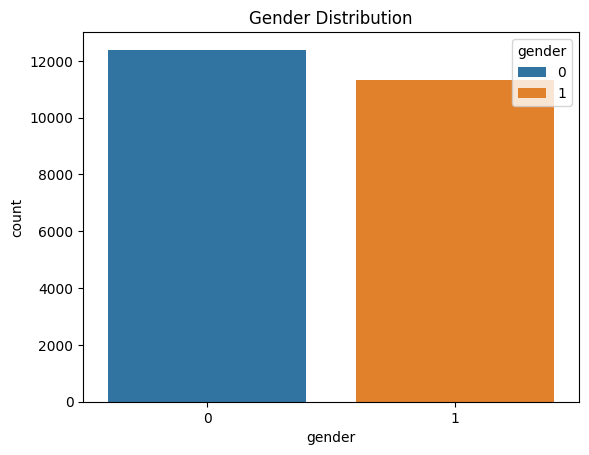

In [7]:
# Plot the gender distribution
sns.countplot(x='gender', data=df, hue='gender', palette=['#1f77b4', '#ff7f0e'])
plt.title("Gender Distribution")
plt.show()

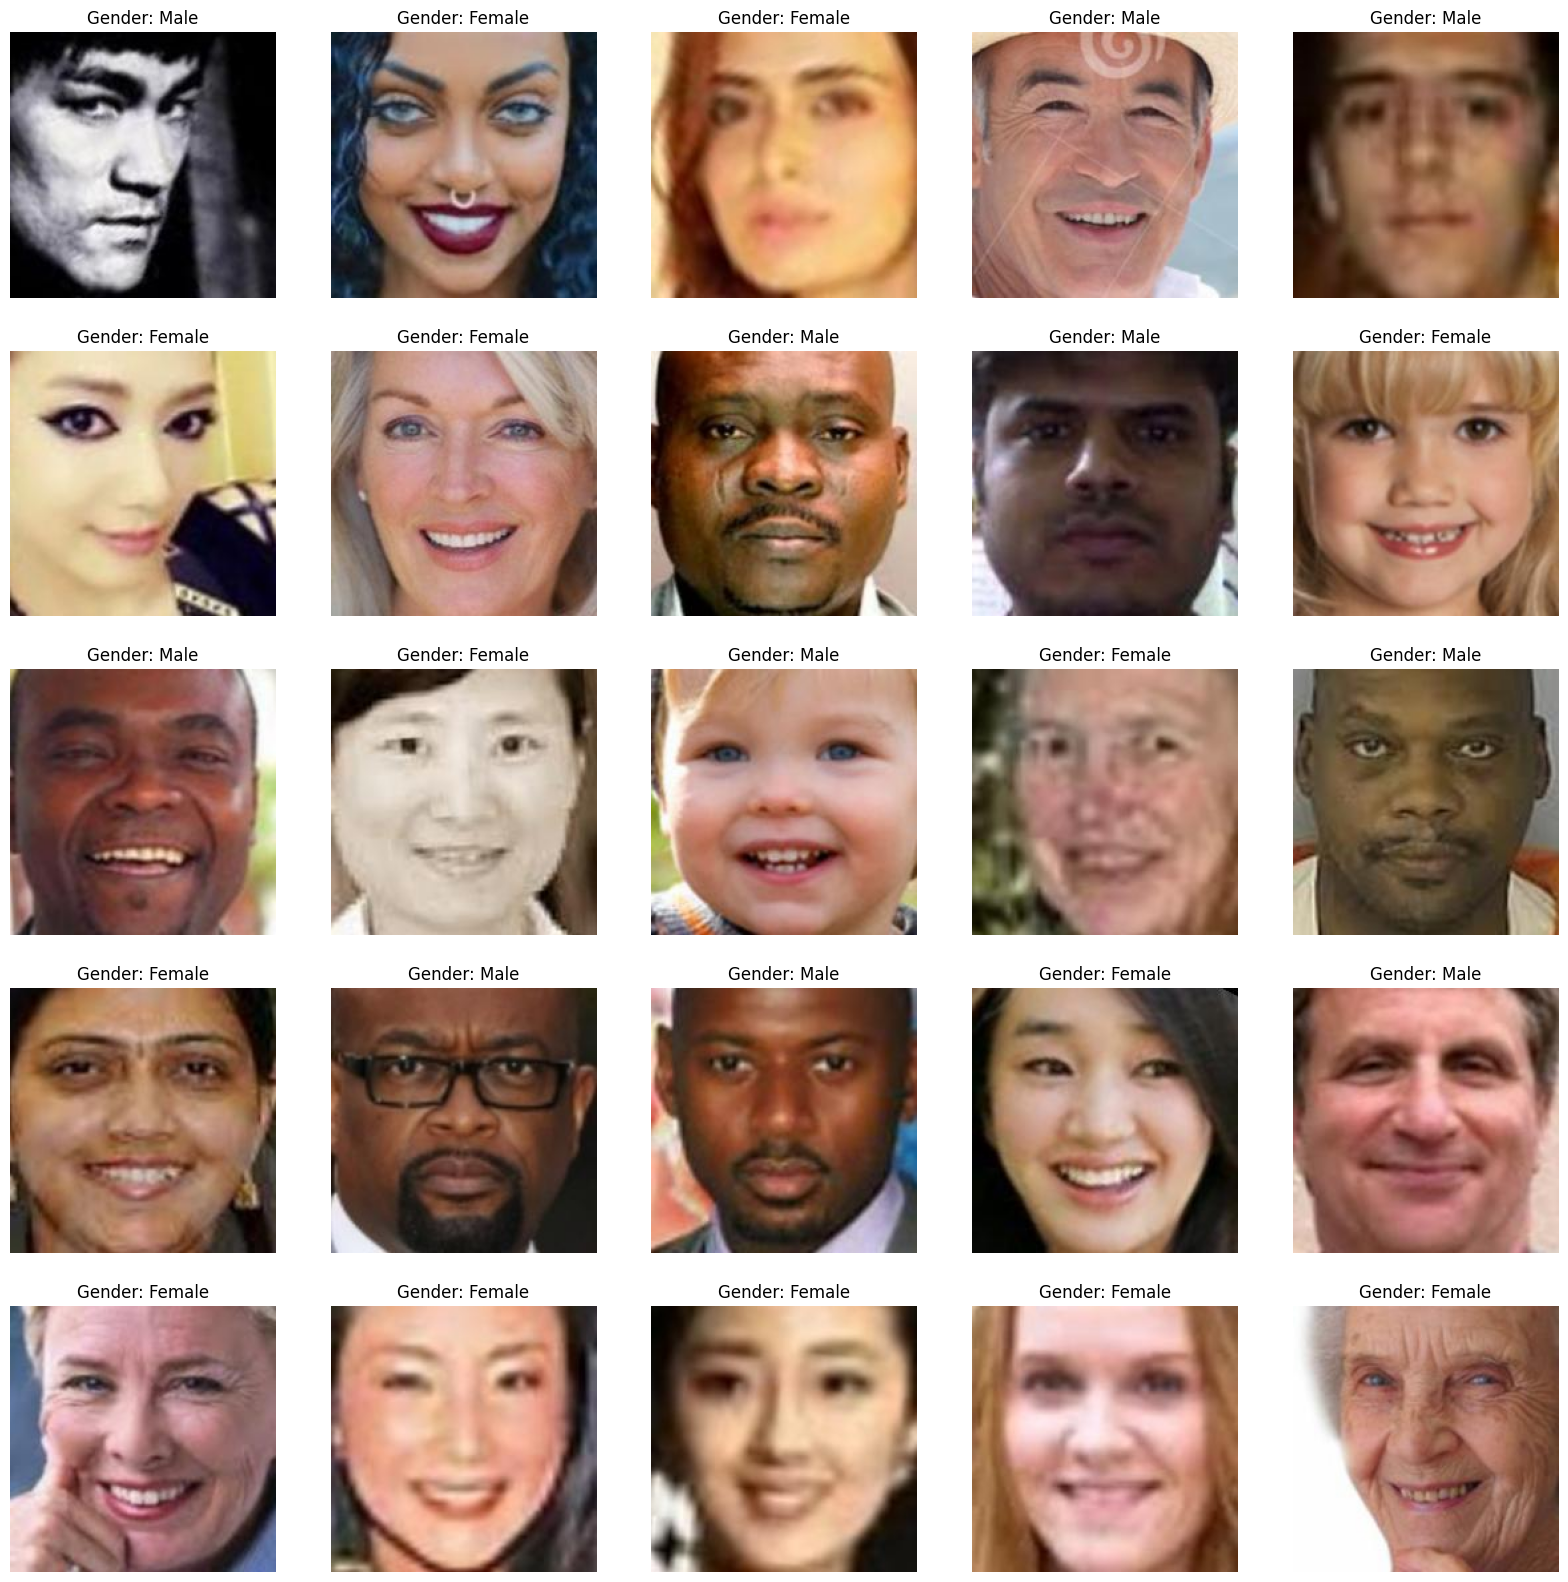

In [8]:
# Display a grid of images with labels
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

# Use plain tuples to access rows
for index, row in enumerate(files.itertuples(index=False, name=None), 1):
    plt.subplot(5, 5, index)
    
    file = row[0]
    gender = row[1]
    
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.show()

### Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
X = extract_features(df['image'])
X = X / 255.0
y_gender = np.array(df['gender'])

100%|██████████| 23708/23708 [00:23<00:00, 1024.22it/s]


In [11]:
X.shape

(23708, 128, 128, 1)

### Model Creation

In [12]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))

# Define the convolutional layers for gender prediction
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
batchnorm_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(batchnorm_1)
dropout_conv_1 = Dropout(0.3)(maxp_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout_conv_1)
batchnorm_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(batchnorm_2)
dropout_conv_2 = Dropout(0.3)(maxp_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout_conv_2)
batchnorm_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)
dropout_conv_3 = Dropout(0.4)(maxp_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(dropout_conv_3)
batchnorm_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)
dropout_conv_4 = Dropout(0.4)(maxp_4)

flatten = Flatten()(dropout_conv_4)

# Fully connected layers with L2 regularization
dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(flatten)
dropout_1 = Dropout(0.5)(dense_1)
output_1 = Dense(1, activation='sigmoid')(dropout_1)

model = Model(inputs=[inputs], outputs=[output_1])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('../models/best_gender_model.keras', monitor='val_loss', save_best_only=True)
]

In [13]:
history = model.fit(
    x=X, 
    y=y_gender,
    batch_size=32, 
    epochs=120, 
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/120
593/593 [==============================] - 25s 37ms/step - loss: 8.8872 - accuracy: 0.6663 - val_loss: 7.1556 - val_accuracy: 0.7602 - lr: 5.0000e-05
Epoch 2/120
593/593 [==============================] - 22s 37ms/step - loss: 5.9779 - accuracy: 0.7436 - val_loss: 4.8245 - val_accuracy: 0.7999 - lr: 5.0000e-05
Epoch 3/120
593/593 [==============================] - 22s 36ms/step - loss: 3.9658 - accuracy: 0.7803 - val_loss: 3.1357 - val_accuracy: 0.8216 - lr: 5.0000e-05
Epoch 4/120
593/593 [==============================] - 22s 36ms/step - loss: 2.5716 - accuracy: 0.8006 - val_loss: 1.9927 - val_accuracy: 0.8484 - lr: 5.0000e-05
Epoch 5/120
593/593 [==============================] - 22s 37ms/step - loss: 1.6700 - accuracy: 0.8202 - val_loss: 1.3054 - val_accuracy: 0.8475 - lr: 5.0000e-05
Epoch 6/120
593/593 [==============================] - 22s 36ms/step - loss: 1.1219 - accuracy: 0.8318 - val_loss: 0.9083 - val_accuracy: 0.8499 - lr: 5.0000e-05
Epoch 7/120
593/593 [=======

#### Execution Time with GPU: 42m 55.6s

### Plot the results

<Figure size 640x480 with 0 Axes>

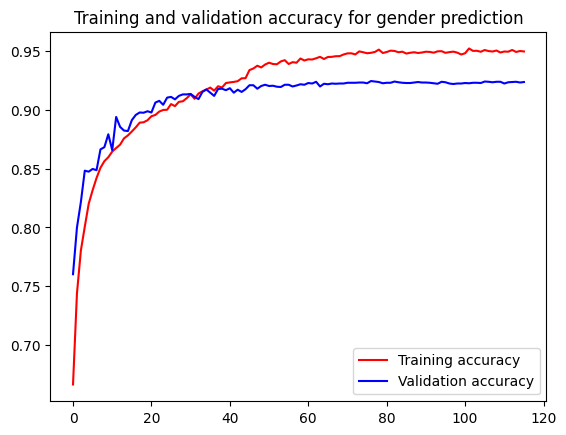

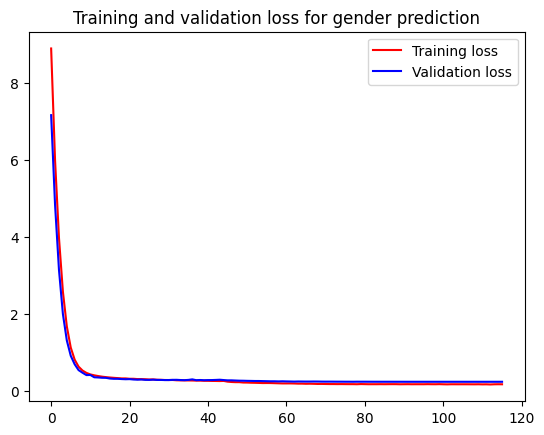

<Figure size 640x480 with 0 Axes>

In [17]:
# Extract accuracy and loss for the gender output
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Look for the correct keys for loss
loss = history.history.get('loss', history.history.get('loss'))
val_loss = history.history.get('val_loss', history.history.get('val_loss'))

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy for gender prediction')
plt.legend()
plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for gender prediction')
plt.legend()
plt.figure()

In [18]:
# Access validation accuracy and loss from the training history
val_gender_accuracy = history.history['val_accuracy'][-1]

print(f"Validation Accuracy for Gender Prediction: {val_gender_accuracy * 100:.2f}%")

Validation Accuracy for Gender Prediction: 92.39%


### Prediction with Test Data

Original Gender:  Female
1/1 [==============================] - 0s 17ms/step
Predicted Gender:  Female


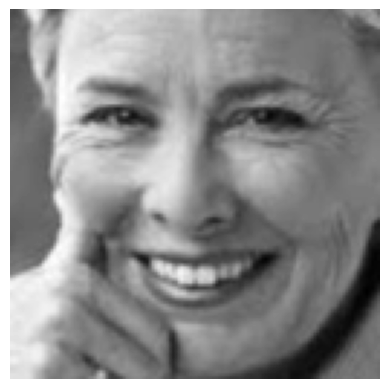

In [19]:
# Gender Prediction Code
image_index = 20
print("Original Gender: ", gender_dict[y_gender[image_index]])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0])]

print("Predicted Gender: ", pred_gender)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()